In [1]:
# !python -m pip install pytorch_lightning torch transformers datasets sklearn torchmetrics wandb matplotlib
import torch
from torch import nn
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers.wandb import WandbLogger
import torchmetrics
from torchmetrics import ConfusionMatrix
from sklearn.metrics import confusion_matrix, accuracy_score

from datasets import load_dataset
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/home/jaekyungcho/anaconda3/envs/mlops/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DataModule(pl.LightningDataModule):
    def __init__(self, model_name="google/bert_uncased_L-2_H-128_A-2", batch_size=32):
        super().__init__()

        self.batch_size = batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(model_name) # Transformer (BERT) model

    def prepare_data(self):
        cola_dataset = load_dataset("glue", "cola")
        self.train_data = cola_dataset["train"]
        self.val_data = cola_dataset["validation"]

    def tokenize_data(self, example):
        # processing the data
        return self.tokenizer(
            example["sentence"],
            truncation=True,
            padding="max_length",
            max_length=256,
        )

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_data = self.train_data.map(self.tokenize_data, batched=True)
            self.train_data.set_format(
                type="torch", columns=["input_ids", "attention_mask", "label"]
            )

            self.val_data = self.val_data.map(self.tokenize_data, batched=True)
            self.val_data.set_format(
                type="torch", columns=["input_ids", "attention_mask", "label"],
                output_all_columns=True,
            )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_data, batch_size=self.batch_size, shuffle=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_data, batch_size=self.batch_size, shuffle=False
        )

In [6]:
class SamplesVisualisationLogger(pl.Callback):
    def __init__(self, datamodule):
        super().__init__()
        self.datamodule = datamodule

    def on_validation_end(self, trainer, pl_module):
        # can be done on complete dataset also
        val_batch = next(iter(trainer.datamodule.val_dataloader()))
        sentences = val_batch["sentence"]

        # get the predictions
        outputs = pl_module(val_batch["input_ids"].to(pl_module.device), val_batch["attention_mask"].to(pl_module.device))
        preds = torch.argmax(outputs, 1)
        labels = val_batch["label"]

        # predicted and labelled data
        df = pd.DataFrame(
            {"Sentence": sentences, "Label": labels.numpy(), "Predicted": preds.detach().cpu().numpy()}
        )

        # wrongly predicted data
        wrong_df = df[df["Label"] != df["Predicted"]]

        # Logging wrongly predicted dataframe as a table
        trainer.logger.experiment.log(
            {
                "examples": wandb.Table(dataframe=wrong_df, allow_mixed_types=True),
                "global_step": trainer.global_step,
            }
        )

In [4]:
class ColaModel(pl.LightningModule):
    def __init__(self, model_name="google/bert_uncased_L-2_H-128_A-2", lr=1e-2):
        super(ColaModel, self).__init__()
        self.save_hyperparameters()

        self.bert = AutoModel.from_pretrained(model_name)
        self.W = nn.Linear(self.bert.config.hidden_size, 2)
        self.num_classes = 2

        self.train_accuracy_metric = torchmetrics.Accuracy()
        self.val_accuracy_metric = torchmetrics.Accuracy()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        h_cls = outputs.last_hidden_state[:, 0]
        logits = self.W(h_cls)
        return logits

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch["input_ids"], batch["attention_mask"])
        loss = F.cross_entropy(logits, batch["label"])

        preds = torch.argmax(logits, 1)
        train_acc = self.train_accuracy_metric(preds, batch["label"])
        self.log("train/loss", loss.detach().cpu(), prog_bar=True, on_epoch=True)
        self.log("train/accuracy", train_acc.detach().cpu(), prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits = self.forward(batch["input_ids"], batch["attention_mask"])
        loss = F.cross_entropy(logits, batch["label"])
        _, preds = torch.max(logits, dim=1)
        val_acc = self.val_accuracy_metric(preds, batch["label"])
        self.log("val/loss", loss.detach().cpu(), prog_bar=True, on_epoch=True)
        self.log("val/acc", val_acc.detach().cpu(), prog_bar=True, on_epoch=True)
        return {"labels": batch["label"], "logits": logits}

    def validation_epoch_end(self, outputs):
        labels = torch.cat([x["labels"] for x in outputs])
        logits = torch.cat([x["logits"] for x in outputs])
        preds = torch.argmax(logits, 1)

        labels = labels.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()
        data = confusion_matrix(labels, preds)
        df_cm = pd.DataFrame(data, columns=np.unique(labels), index=np.unique(labels))
        df_cm.index.name = "Actual"
        df_cm.columns.name = "Predicted"
        plt.figure(figsize=(7, 4))
        plot = sns.heatmap(
            df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}
        )  # font size
        self.logger.experiment.log({"Confusion Matrix": wandb.Image(plot)})

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams["lr"])

In [5]:
class ColaPredictor:
    def __init__(self, model_path):
        self.model_path = model_path
        # loading the trained model
        self.model = ColaModel.load_from_checkpoint(model_path)
        # keep the model in eval mode
        self.model.eval()
        self.model.freeze()
        self.processor = DataModule()
        self.softmax = torch.nn.Softmax(dim=0)
        self.lables = ["unacceptable", "acceptable"]

    def predict(self, text):
        # text => run time input
        inference_sample = {"sentence": text}
        # tokenizing the input
        processed = self.processor.tokenize_data(inference_sample)
        # predictions
        logits = self.model(
            torch.tensor([processed["input_ids"]]),
            torch.tensor([processed["attention_mask"]]),
        )
        scores = self.softmax(logits[0]).detach().cpu().numpy().tolist()
        predictions = []
        for score, label in zip(scores, self.lables):
            predictions.append({"label": label, "score": score})
        return predictions

Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environmen

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Found cached dataset glue (/home/jaekyungcho/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 2/2 [00:00<00:00, 19.30ba/s]
/home/jaekyungcho/anaconda3/envs/mlops/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/jaekyungcho/MLOps/Raviraja/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                  | Type      | Params
----------------------------------------------------
0 | bert                  | BertModel | 4.4 M 
1 | W                     | Linear    | 258   
2 | train_accuracy_metric | Accuracy  | 0     
3 | val_accuracy_metric   | Accuracy  | 0     
--------------

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jaekyungcho/anaconda3/envs/mlops/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jaekyungcho/anaconda3/envs/mlops/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


/home/jaekyungcho/anaconda3/envs/mlops/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 301/301 [00:09<00:00, 32.86it/s, loss=0.653, v_num=c3xk, train/loss_step=1.030, train/accuracy_step=0.429]

/home/jaekyungcho/anaconda3/envs/mlops/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 19. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0: 100%|██████████| 301/301 [00:09<00:00, 31.43it/s, loss=0.653, v_num=c3xk, train/loss_step=1.030, train/accuracy_step=0.429, val/loss=0.643, val/acc=0.691]

Metric val/loss improved. New best score: 0.643


Epoch 1: 100%|██████████| 301/301 [00:09<00:00, 31.39it/s, loss=0.621, v_num=c3xk, train/loss_step=0.605, train/accuracy_step=0.714, val/loss=0.619, val/acc=0.691, train/loss_epoch=0.651, train/accuracy_epoch=0.700]

Metric val/loss improved by 0.023 >= min_delta = 0.0. New best score: 0.619


Epoch 2: 100%|██████████| 301/301 [00:09<00:00, 32.51it/s, loss=0.61, v_num=c3xk, train/loss_step=0.603, train/accuracy_step=0.714, val/loss=0.619, val/acc=0.691, train/loss_epoch=0.609, train/accuracy_epoch=0.704] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 301/301 [00:09<00:00, 32.49it/s, loss=0.61, v_num=c3xk, train/loss_step=0.603, train/accuracy_step=0.714, val/loss=0.619, val/acc=0.691, train/loss_epoch=0.609, train/accuracy_epoch=0.704]


epoch,▁▁▁▁▁▁▁▅▅▅▅▅▅▅████████
global_step,▁▃▆█
train/accuracy_epoch,▁██
train/accuracy_step,▇▄▅▅▄▃█▃█▃▅▇▁▆▇▃
train/loss_epoch,█▂▁
train/loss_step,▃▇▅▅▇▆▁█▂▇▅▃█▄▃▇
trainer/global_step,▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇█████
val/acc,▁▁▁
val/loss,█▁▁
epoch,2
global_step,804


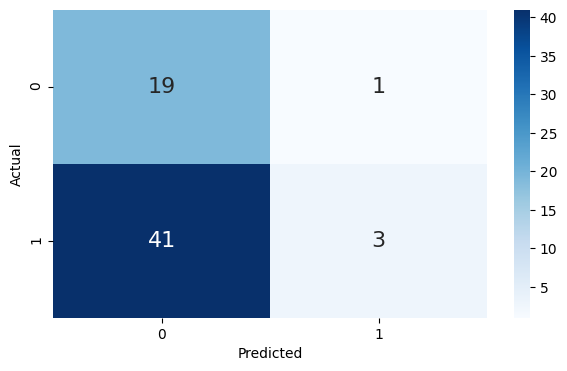

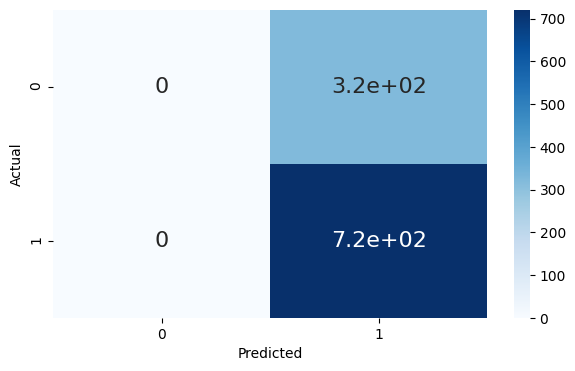

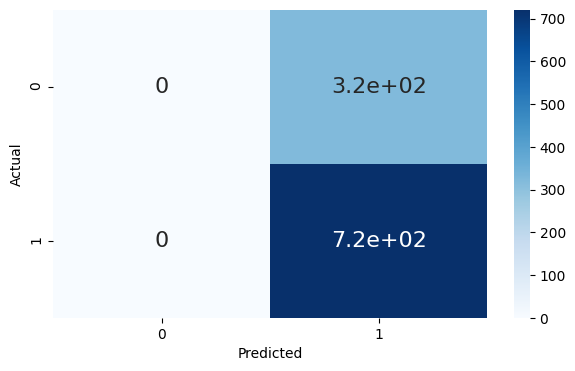

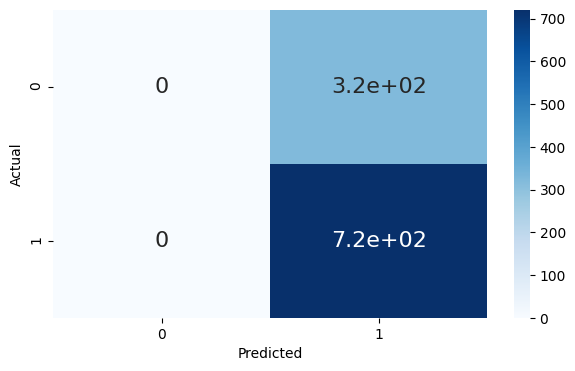

In [7]:
cola_data = DataModule()
cola_model = ColaModel()

checkpoint_callbacks = [
    ModelCheckpoint(dirpath="./models", monitor="val/loss", mode="min", filename="best-checkpoint"),
    EarlyStopping(monitor="val/loss", patience=3, verbose=True, mode="min"),
    SamplesVisualisationLogger(cola_data) # 요놈이 문제
]

wandb_logger = WandbLogger(project="MLOps Basics")

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=3,
    fast_dev_run=False, # True: one batch training one validation -> for debugging
    logger=wandb_logger, # directory: logs/cola
    # logger = pl.loggers.WandbLogger(name='cola',project='pytorchlightning')
    callbacks=checkpoint_callbacks,
)
trainer.fit(cola_model, cola_data)

wandb.finish()